In [16]:
# Import libraries. You may or may not use all of these.
# !pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

from IPython.display import display
import jupyter_black
jupyter_black.load(lab=False)

In [17]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv("insurance.csv")
print(dataset.shape)
dataset.tail()

(1338, 7)


,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [18]:
# Extract the labels
labels = dataset.pop("expenses")

In [19]:
# PREPROCESSING: ROUND 1
# Convert categorical features ('sex', 'smoker', 'region') to integer dummies
dataset = pd.get_dummies(dataset, columns=["sex", "smoker", "region"], dtype="float64")
display(dataset.head())

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.9,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,18,33.8,1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,28,33.0,3,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,33,22.7,0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,32,28.9,0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


In [20]:
# GET TRAIN, TEST, AND VALIDATION DATA SETS
# Split data into training and testing data sets first
train_dataset, test_dataset, train_labels, test_labels = train_test_split(
    dataset, labels, test_size=0.2, random_state=10
)

# Also create a small validation data set
train_dataset, val_dataset, train_labels, val_labels = train_test_split(
    train_dataset, train_labels, test_size=0.18, random_state=10
)

In [21]:
# PREPROCESSING: ROUND 2
# Use sklearn's PowerTransformer on 'age', 'bmi', and 'children'
# Fit only on train data (!):
tmp_col_list = ["age", "bmi", "children"]
power_transformer = PowerTransformer()
power_transformer.fit(train_dataset[tmp_col_list])

# Transform columns:
train_dataset[tmp_col_list] = power_transformer.transform(train_dataset[tmp_col_list])
test_dataset[tmp_col_list] = power_transformer.transform(test_dataset[tmp_col_list])
val_dataset[tmp_col_list] = power_transformer.transform(val_dataset[tmp_col_list])

display(train_dataset.head())
print(train_dataset.dtypes)

# For Tensorflow, the final data needs to be in numpy format:
train_dataset = train_dataset.values
test_dataset = test_dataset.values
val_dataset = val_dataset.values
train_labels = train_labels.values
test_labels = test_labels.values
val_labels = val_labels.values

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
106,-1.498146,-0.325894,0.306879,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
956,1.036806,0.073224,0.306879,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1296,-1.591854,-0.723157,-1.065537,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
181,-1.591854,1.236187,-1.065537,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
790,0.076876,1.742570,-1.065537,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


age                 float64
bmi                 float64
children            float64
sex_female          float64
sex_male            float64
smoker_no           float64
smoker_yes          float64
region_northeast    float64
region_northwest    float64
region_southeast    float64
region_southwest    float64
dtype: object


In [22]:
# BUILD THE MODEL (a fairly simple one)
model = keras.Sequential()

input_layer = layers.Input(shape=(train_dataset.shape[1],), dtype="float64")
dense_layer_0 = layers.Dense(16, activation="relu")
dense_layer_1 = layers.Dense(8, activation="relu")
output_layer = layers.Dense(1)

model.add(input_layer)
model.add(dense_layer_0)
model.add(dense_layer_1)
model.add(output_layer)

model.compile(
    optimizer="adam",
    loss="mean_absolute_error",
    metrics=["mean_absolute_error", "mean_squared_error"],
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 16)                192       
                                                                 
 dense_7 (Dense)             (None, 8)                 136       
                                                                 
 dense_8 (Dense)             (None, 1)                 9         
                                                                 
Total params: 337
Trainable params: 337
Non-trainable params: 0
_________________________________________________________________


In [23]:
# TRAIN THE MODEL
# Init a training data generator that randomly
# yiels approx. half of the training data
def train_data_generator():
    data_len = train_dataset.shape[0]
    while True:
        mask = np.random.random_sample(data_len) <= 0.5
        yield (train_dataset[mask, :], train_labels[mask])


train_data_gen = train_data_generator()

# Early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta=0, 
    patience=4, 
    verbose=0, 
    mode='auto', 
    baseline=None, 
    restore_best_weights=True
)

# Fit
history = model.fit(
    x=train_data_gen,
    validation_data=(val_dataset, val_labels),
    epochs=20,
    steps_per_epoch=2048,
    callbacks=[early_stopping_callback]
)

Epoch 1/20
2048/2048 [==============================] - 4s 2ms/step - loss: 10871.3486 - mean_absolute_error: 10871.3486 - mean_squared_error: 263989472.0000 - val_loss: 6457.1514 - val_mean_absolute_error: 6457.1514 - val_mean_squared_error: 136288272.0000
Epoch 2/20
2048/2048 [==============================] - 4s 2ms/step - loss: 6293.8486 - mean_absolute_error: 6293.8486 - mean_squared_error: 134668896.0000 - val_loss: 4507.6987 - val_mean_absolute_error: 4507.6987 - val_mean_squared_error: 89932448.0000
Epoch 3/20
2048/2048 [==============================] - 4s 2ms/step - loss: 4042.3770 - mean_absolute_error: 4042.3770 - mean_squared_error: 70525800.0000 - val_loss: 2883.3862 - val_mean_absolute_error: 2883.3862 - val_mean_squared_error: 40690276.0000
Epoch 4/20
2048/2048 [==============================] - 4s 2ms/step - loss: 3261.9636 - mean_absolute_error: 3261.9636 - mean_squared_error: 43465084.0000 - val_loss: 2349.9055 - val_mean_absolute_error: 2349.9055 - val_mean_squared_

9/9 - 0s - loss: 1874.2056 - mean_absolute_error: 1874.2056 - mean_squared_error: 27418376.0000 - 30ms/epoch - 3ms/step
Testing set Mean Abs Error: 1874.21 expenses
You passed the challenge. Great job!
9/9 [==============================] - 0s 1ms/step


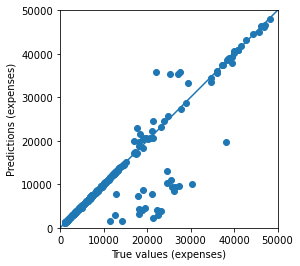

In [24]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
